In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Conv2D,BatchNormalization,Activation,MaxPooling2D,AveragePooling2D
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import pandas as pd

In [2]:
train_path = '/content/drive/MyDrive/Datasets/maskdata/maskdata/train'
test_path = '/content/drive/MyDrive/Datasets/maskdata/maskdata/test'
validation_path = '/content/drive/MyDrive/Datasets/maskdata/maskdata/validation1'

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True,validation_split=0.4)
#test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True,validation_split=0.4)

train_dataset = train_datagen.flow_from_directory(train_path,
                                          target_size=(224,224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_dataset = train_datagen.flow_from_directory(test_path,
                                        target_size=(224,224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

CLASSES=['GOOD! YOU ARE SAFE!!','PLEASE!! WEAR YOUR MASK!']

Found 370 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [ ]:
#test_dataset = train_datagen.flow_from_directory(validation_path,
#                                                 target_size=(224,224),
 #                                                batch_size=1,
  #                                               class_mode='categorical',
#                                                 subset='validation')

Found 4 images belonging to 2 classes.


In [6]:
train_dataset.class_indices

{'with_mask': 0, 'without_mask': 1}

In [9]:
#train_dataset[0]

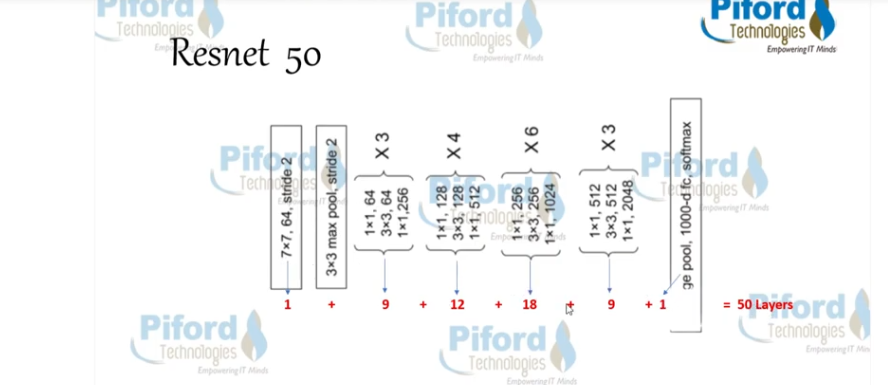

In [53]:
filterCount = cv2.imread('/content/drive/MyDrive/Screenshot (15).png')
cv2_imshow(filterCount)

In [7]:
def identity_block(x,f,filters):
  F1,F2,F3 = filters
  x_temp = x

  #First layer
  x = Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid')(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)

  #Second layer
  x = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)

  #Third layer
  x = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(x)
  x = BatchNormalization(axis=3)(x)

  #Final Step
  x = tf.keras.layers.Add()([x,x_temp])
  x = Activation('relu')(x)

  return x

In [8]:
def convolutional_block(x,f,filters,s=2):
  F1,F2,F3 = filters
  x_temp = x

  #First layer
  x = Conv2D(F1,(1,1),strides=(s,s))(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)

  #Second layer
  x = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)

  #Third layer
  x = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(x)
  x = BatchNormalization(axis=3)(x)

  #Shortcut Layer
  x_temp = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding='valid')(x_temp)
  x_temp = BatchNormalization(axis=3)(x_temp)

  #Final layer
  x = tf.keras.layers.Add()([x,x_temp])
  x = Activation('relu')(x)
  
  return x

ResNet 50 Structure

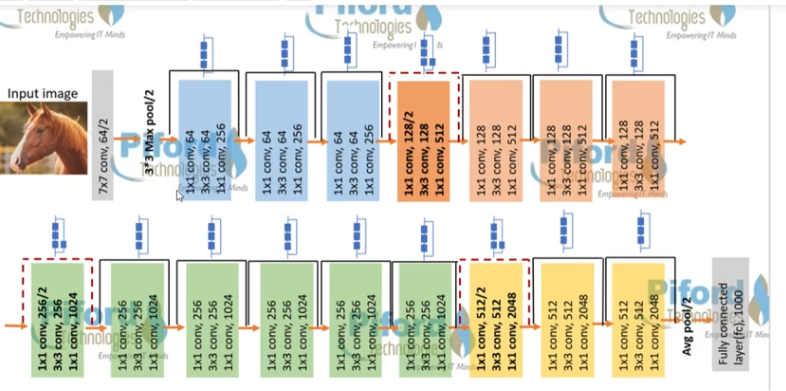

In [52]:
resnet = cv2.imread('/content/drive/MyDrive/Screenshot (377).png')
cv2_imshow(resnet)

In [9]:
def ResNet50(input_shape=(224,224,3),classes=2):
  
  x_input = tf.keras.layers.Input(input_shape)
  x = tf.keras.layers.ZeroPadding2D((3,3))(x_input)

  #stage 1
  x = Conv2D(64,(7,7),strides=(2,2))(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3,3),strides=(2,2))(x)

  #stage 2
  x = convolutional_block(x,f=3,filters=[64,64,256],s=1)
  x = identity_block(x,3,[64,64,256])
  x = identity_block(x,3,[64,64,256])

  #stage 3
  x = convolutional_block(x,f=3,filters=[128,128,512],s=2)
  x = identity_block(x,3,[128,128,512])
  x = identity_block(x,3,[128,128,512])
  x = identity_block(x,3,[128,128,512])

  #stage 4
  x = convolutional_block(x,f=3,filters=[256,256,1024],s=2)
  x = identity_block(x,3,[256,256,1024])
  x = identity_block(x,3,[256,256,1024])
  x = identity_block(x,3,[256,256,1024])
  x = identity_block(x,3,[256,256,1024])
  x = identity_block(x,3,[256,256,1024])

  #stage 5
  x = convolutional_block(x,f=3,filters=[512,512,2048],s=2)
  x = identity_block(x,3,[512,512,2048])
  x = identity_block(x,3,[512,512,2048])
  
  #AvgPool
  x = AveragePooling2D((2,2),name="avg_pool")(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(classes,activation='softmax',name='fc' + str (classes),kernel_initializer=glorot_uniform(seed=0))(x)

  model = tf.keras.Model(inputs = x_input, outputs = x, name = 'ResNet50')

  return model
  

In [10]:
model = ResNet50(input_shape=(224,224,3),classes=2)
  
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'batch_normalizati

In [11]:
model.fit(train_dataset,
          epochs=30,
          batch_size=32)

Epoch 1/30
12/12 [==============================] - 72s 5s/step - loss: 21.9615 - accuracy: 0.5568
Epoch 2/30
12/12 [==============================] - 5s 374ms/step - loss: 4.8666 - accuracy: 0.7189
Epoch 3/30
12/12 [==============================] - 5s 375ms/step - loss: 2.1394 - accuracy: 0.8405
Epoch 4/30
12/12 [==============================] - 5s 372ms/step - loss: 1.6795 - accuracy: 0.8838
Epoch 5/30
12/12 [==============================] - 5s 389ms/step - loss: 1.2036 - accuracy: 0.8973
Epoch 6/30
12/12 [==============================] - 5s 394ms/step - loss: 1.2273 - accuracy: 0.9162
Epoch 7/30
12/12 [==============================] - 5s 375ms/step - loss: 0.8100 - accuracy: 0.9081
Epoch 8/30
12/12 [==============================] - 5s 383ms/step - loss: 0.9820 - accuracy: 0.9108
Epoch 9/30
12/12 [==============================] - 5s 371ms/step - loss: 0.6944 - accuracy: 0.9108
Epoch 10/30
12/12 [==============================] - 5s 374ms/step - loss: 0.4548 - accuracy: 0.9270


In [19]:
val_loss,val_acc = model.evaluate(train_dataset)
print(val_loss,val_acc)

12/12 [==============================] - 5s 377ms/step - loss: 0.1783 - accuracy: 0.9811
0.1783190369606018 0.9810810685157776


-------------------------------------------------------------------------------------------------------------------


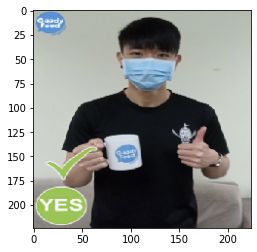


GOOD! YOU ARE SAFE!!
-------------------------------------------------------------------------------------------------------------------


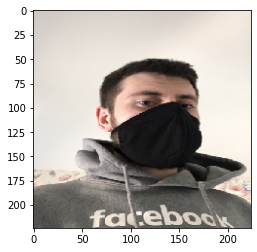


GOOD! YOU ARE SAFE!!
-------------------------------------------------------------------------------------------------------------------


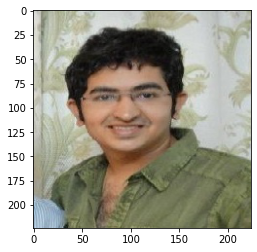


PLEASE!! WEAR YOUR MASK!
-------------------------------------------------------------------------------------------------------------------


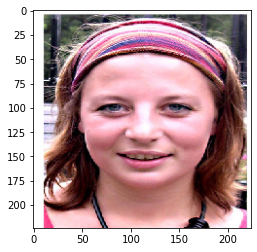


PLEASE!! WEAR YOUR MASK!
-------------------------------------------------------------------------------------------------------------------


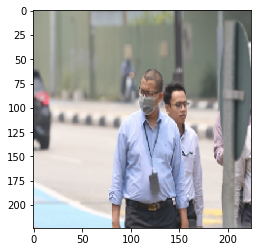


GOOD! YOU ARE SAFE!!


In [48]:
path = '/content/drive/MyDrive/Datasets/maskdata/maskdata/validation1/validphotos'

for i in os.listdir(path):
  p = path + '/' + i
  img = load_img(p,target_size=(224,224))
  x = img_to_array(img)
  x = np.expand_dims(x,axis=0)
  x = preprocess_input(x)
  out = model.predict(x)
  prediction = int (out[0][1])
  print("-------------------------------------------------------------------------------------------------------------------")
  plt.imshow(img)
  plt.show()
  print()
  print(CLASSES[0]) if (prediction==0) else print(CLASSES[1])